## Direction

## Target=お弁当の売り上げ数を予測(回帰問題)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font="IPAexGothic",style="white")

Duplicate key in file PosixPath('/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 250 ('font.family : IPAexGothic')


## 基礎分析

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv",header=None)
print("Data Shapes")
print("Train:",train.shape, "Test:",test.shape, "Sample:",sample.shape)

Data Shapes
Train: (207, 12) Test: (40, 11) Sample: (40, 2)


In [3]:
train.index = pd.to_datetime(train["datetime"])
train.head()

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
datetime,,,,,,,,,,,,
2013-11-18,2013-11-18,90,月,0,厚切りイカフライ,NaN,NaN,NaN,NaN,快晴,--,19.8
2013-11-19,2013-11-19,101,火,1,手作りヒレカツ,NaN,NaN,NaN,NaN,快晴,--,17.0
2013-11-20,2013-11-20,118,水,0,白身魚唐揚げ野菜あん,NaN,NaN,NaN,NaN,快晴,--,15.5
2013-11-21,2013-11-21,120,木,1,若鶏ピリ辛焼,NaN,NaN,NaN,NaN,快晴,--,15.2
2013-11-22,2013-11-22,130,金,1,ビッグメンチカツ,NaN,NaN,NaN,NaN,快晴,--,16.1


In [4]:
train.describe()

,y,soldout,kcal,payday,temperature
count,207.000000,207.000000,166.000000,10.0,207.000000
mean,86.623188,0.449275,404.409639,1.0,19.252174
std,32.882448,0.498626,29.884641,0.0,8.611365
min,29.000000,0.000000,315.000000,1.0,1.200000
25%,57.000000,0.000000,386.000000,1.0,11.550000
50%,78.000000,0.000000,408.500000,1.0,19.800000
75%,113.000000,1.000000,426.000000,1.0,26.100000
max,171.000000,1.000000,462.000000,1.0,34.600000


In [5]:
train.describe(include="O")  #include object

,datetime,week,name,remarks,event,weather,precipitation
count,207,207,207,21,14,207,207
unique,207,5,156,6,2,7,8
top,2014-1-27,木,タンドリーチキン,お楽しみメニュー,ママの会,快晴,--
freq,1,43,6,12,9,53,169


## 欠損値補間と月情報の特徴量の作成

In [6]:
train["payday"] = train["payday"].fillna(0)
train["precipitation"] = train["precipitation"].apply(lambda x : -1 if x == "--" else float(x))
train["event"] = train["event"].fillna("なし")
train["remarks"] = train["remarks"].fillna("なし")
train["month"] = train["datetime"].apply(lambda x : int(x.split("-")[1]))

In [7]:
train["precipitation"].value_counts()

-1.0    169
 0.0     23
 0.5      9
 1.5      2
 2.5      1
 1.0      1
 6.5      1
 6.0      1
Name: precipitation, dtype: int64

## お弁当の売り上げ分布の確認

<AxesSubplot:xlabel='datetime'>

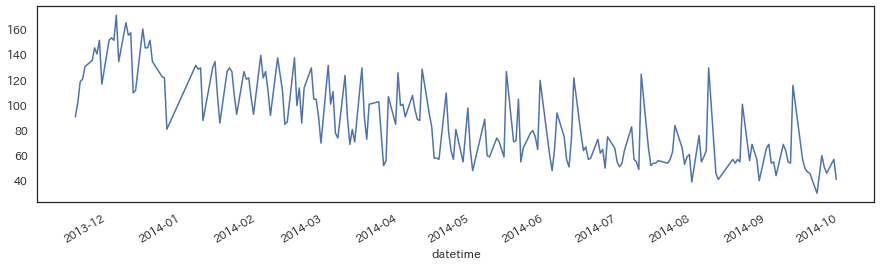

In [8]:
train["y"].plot(figsize=(15,4))

- 経時変化あり
- スパイクあり

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

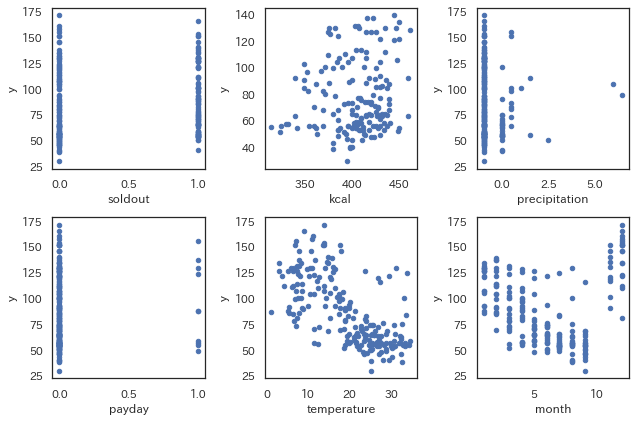

In [9]:
fig, ax = plt.subplots(2,3,figsize=(9,6))                         #2行3列
train.plot.scatter(x="soldout", y="y", ax=ax[0][0])
train.plot.scatter(x="kcal", y="y", ax=ax[0][1])
train.plot.scatter(x="precipitation", y="y", ax=ax[0][2])
train.plot.scatter(x="payday", y="y", ax=ax[1][0])
train.plot.scatter(x="temperature", y="y", ax=ax[1][1])
train.plot.scatter(x="month", y="y", ax=ax[1][2])
plt.tight_layout()

temperatureとmonthが相関ありそう
（ただし時間依存あるので代替変数の可能性高い）

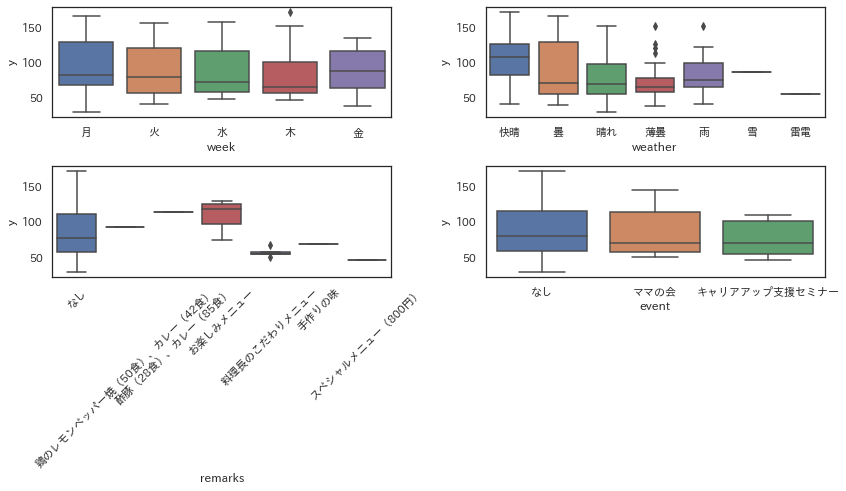

In [10]:
fig, ax = plt.subplots(2,2,figsize=(12,7))
sns.boxplot(x="week",y="y",data=train,ax=ax[0][0])
sns.boxplot(x="weather",y="y",data=train,ax=ax[0][1])
sns.boxplot(x="remarks",y="y",data=train,ax=ax[1][0])
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(),rotation=45)
sns.boxplot(x="event",y="y",data=train,ax=ax[1][1])
plt.tight_layout()

お楽しみメニュー有り無しが影響ありそう

お楽しみメニューあり

<AxesSubplot:xlabel='datetime'>

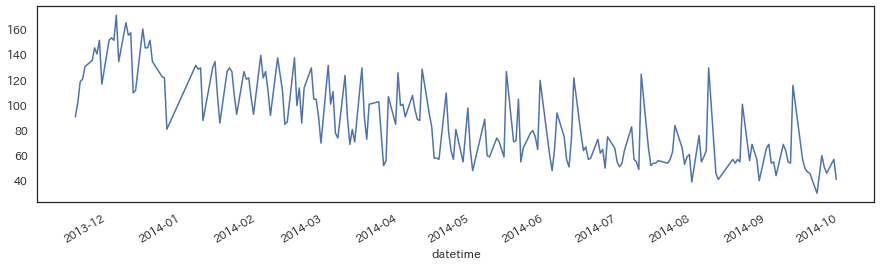

In [11]:
train["y"].plot(figsize=(15,4))

お楽しみメニューなし

<AxesSubplot:xlabel='datetime'>

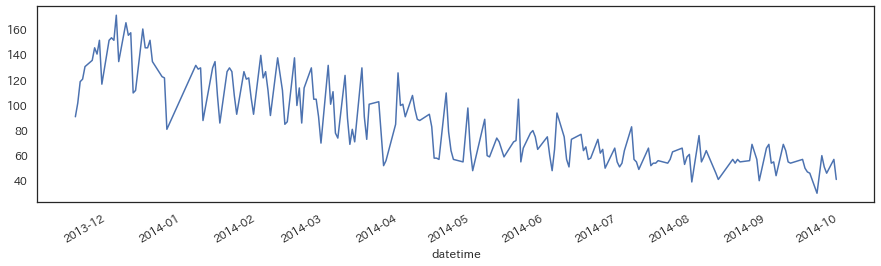

In [12]:
train[train["remarks"]!="お楽しみメニュー"]["y"].plot(figsize=(15,4))

お楽しみメニューを除いても、まだスパイクあり

<AxesSubplot:xlabel='fun', ylabel='y'>

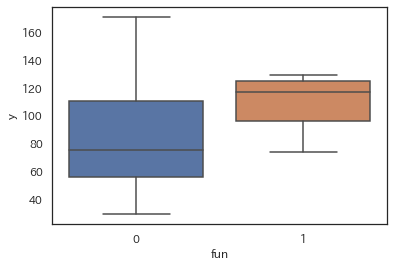

In [13]:
train["fun"] = train["remarks"].apply(lambda x: 1 if x=="お楽しみメニュー" else 0)
sns.boxplot(x="fun",y="y",data=train)

## 中央値検定(メディアン検定)

2標本それぞれについてmより大きい（もしくはm以上の）データの件数とm以下（もしくはm未満）のデータの件数を求め、2行×2列の分割表を作成する。この分割表に対してカイ二乗検定を行い、2標本の分布が独立かどうかを検定する。

In [14]:
from scipy.stats import median_test
stat,p,med,tbl = median_test(train[train["fun"]==1]["y"],train[train["fun"]==0]["y"])
print("p",p,"stat",stat)

p 0.007057960766247775 stat 7.2581589841730345


p値が0.05以下なので有意差あり

↓お楽しみメニューだけでも差はあり

<AxesSubplot:xlabel='datetime'>

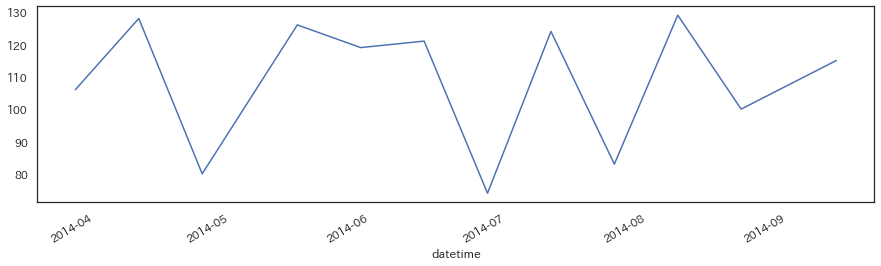

In [15]:
train[train["remarks"]=="お楽しみメニュー"]["y"].plot(figsize=(15,4))

In [16]:
train[train["remarks"]=="お楽しみメニュー"]

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature,month,fun
datetime,,,,,,,,,,,,,,
2014-03-28,2014-3-28,106,金,0,キーマカレー,NaN,お楽しみメニュー,なし,0.0,快晴,-1.0,18.5,3,1
2014-04-11,2014-4-11,128,金,1,チキンカレー,NaN,お楽しみメニュー,なし,0.0,快晴,-1.0,16.5,4,1
2014-04-25,2014-4-25,80,金,0,中華丼,NaN,お楽しみメニュー,なし,0.0,晴れ,-1.0,20.8,4,1
2014-05-16,2014-5-16,126,金,0,ポークカレー,NaN,お楽しみメニュー,ママの会,0.0,快晴,-1.0,23.8,5,1
2014-05-30,2014-5-30,119,金,0,チキンカレー,NaN,お楽しみメニュー,なし,0.0,薄曇,-1.0,26.9,5,1
2014-06-13,2014-6-13,121,金,0,キーマカレー,NaN,お楽しみメニュー,なし,0.0,晴れ,-1.0,29.5,6,1
2014-06-27,2014-6-27,74,金,0,牛丼,NaN,お楽しみメニュー,なし,0.0,雨,0.0,25.4,6,1
2014-07-11,2014-7-11,124,金,0,ポークカレー,NaN,お楽しみメニュー,なし,0.0,晴れ,-1.0,33.9,7,1
2014-07-25,2014-7-25,83,金,0,ひやしたぬきうどん・炊き込みご飯,NaN,お楽しみメニュー,なし,0.0,晴れ,-1.0,33.6,7,1


カレーの時が高そう

<AxesSubplot:xlabel='curry', ylabel='y'>

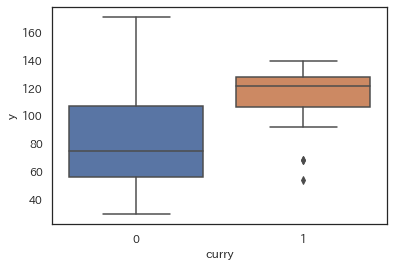

In [17]:
train["curry"] = train["name"].apply(lambda x : 1 if x.find("カレー")>=0 else 0)
sns.boxplot(x="curry",y="y",data=train)

In [18]:
stat,p,med,tbl = median_test(train[train["curry"]==1]["y"],train[train["curry"]==0]["y"])
print("p:",p,"stat",stat)

p: 0.010699742900892427 stat 6.514516162828877


## Method

以下はオリジナル
1. トレンドが異なる2014-05-01以前のデータ削除
2. 説明変数は"precipitation","weather","days","fun","curry"
3. "weather_雷電"はtestデータになかったので削除 　→結果的にRMSEは上昇
4. 単回帰とRandomForrestモデルを組み合わせ

In [19]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv",header=None)

In [102]:
train.index = pd.to_datetime(train["datetime"])
train = train["2014-05-01":]
train = train.reset_index(drop=True)

In [103]:
train.head()

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature,fun,curry,days
0,2014-5-1,64,木,0,マーボ茄子,415.0,NaN,NaN,NaN,晴れ,-1.0,24.0,0,0,104
1,2014-5-2,47,金,0,鶏の天ぷら,420.0,NaN,NaN,NaN,晴れ,-1.0,23.3,0,0,105
2,2014-5-7,88,水,1,肉じゃが,415.0,NaN,NaN,NaN,晴れ,-1.0,18.9,0,0,106
3,2014-5-8,59,木,0,メンチカツ,405.0,NaN,NaN,NaN,薄曇,-1.0,21.0,0,0,107
4,2014-5-9,58,金,1,手作りチキンカツ,434.0,NaN,NaN,1.0,晴れ,-1.0,23.4,0,0,108


In [104]:
train["days"] = train.index
train["precipitation"] = train["precipitation"].apply(lambda x : -1 if x=="--" else x).astype(np.float)
train["fun"] = train["remarks"].apply(lambda x: 1 if x=="お楽しみメニュー" else 0)
train["curry"] = train["name"].apply(lambda x : 1 if x.find("カレー")>=0 else 0)

cols = ["precipitation","weather","days","fun","curry","y"]

<ipython-input-104-461e686da040>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train["precipitation"] = train["precipitation"].apply(lambda x : -1 if x=="--" else x).astype(np.float)


In [105]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestRegressor as RF

In [169]:
def learning(trainX,y_train):
    model1 = LR()
    model2 = RF(n_estimators=100,max_depth=4,random_state=None)
    model1.fit(trainX["days"].values.reshape(-1,1),y_train)
    pred = model1.predict(trainX["days"].values.reshape(-1,1))
    
    pred_sub = y_train - pred
    model2.fit(trainX,pred_sub)
    return model1, model2

In [170]:
train.head()

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature,fun,curry,days
0,2014-5-1,64,木,0,マーボ茄子,415.0,NaN,NaN,NaN,晴れ,-1.0,24.0,0,0,0
1,2014-5-2,47,金,0,鶏の天ぷら,420.0,NaN,NaN,NaN,晴れ,-1.0,23.3,0,0,1
2,2014-5-7,88,水,1,肉じゃが,415.0,NaN,NaN,NaN,晴れ,-1.0,18.9,0,0,2
3,2014-5-8,59,木,0,メンチカツ,405.0,NaN,NaN,NaN,薄曇,-1.0,21.0,0,0,3
4,2014-5-9,58,金,1,手作りチキンカツ,434.0,NaN,NaN,1.0,晴れ,-1.0,23.4,0,0,4


In [171]:
trainX = pd.get_dummies(train[["precipitation","weather","days","fun","curry"]])
y_train = train["y"]
trainX.head()

,precipitation,days,fun,curry,weather_快晴,weather_晴れ,weather_曇,weather_薄曇,weather_雨,weather_雷電
0,-1.0,0,0,0,0,1,0,0,0,0
1,-1.0,1,0,0,0,1,0,0,0,0
2,-1.0,2,0,0,0,1,0,0,0,0
3,-1.0,3,0,0,0,0,0,1,0,0
4,-1.0,4,0,0,0,1,0,0,0,0


In [172]:
trainX = trainX.drop("weather_雷電",axis=1)

In [173]:
model1, model2 = learning(trainX, y_train)

In [174]:
pred_train = model1.predict(trainX["days"].values.reshape(-1,1)) + model2.predict(trainX)

In [175]:
from sklearn.metrics import mean_squared_error as MSE
print("RMSE",MSE(y_train, pred_train)**0.5)

RMSE 8.020771449177138


RMSE 8.020771449177138


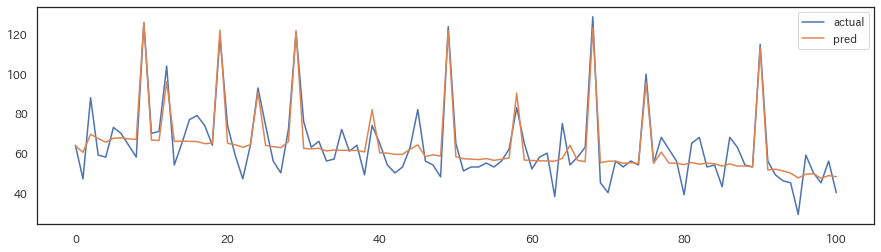

In [176]:
p = pd.DataFrame({"actual":y_train,"pred":pred_train})
p.plot(figsize=(15,4))
print("RMSE",MSE(y_train,pred_train)**0.5)

In [177]:
test["days"] = test.index
test["precipitation"] = test["precipitation"].apply(lambda x : -1 if x=="--" else x).astype(np.float)
test["fun"] = test["remarks"].apply(lambda x: 1 if x=="お楽しみメニュー" else 0)
test["curry"] = test["name"].apply(lambda x : 1 if x.find("カレー")>=0 else 0)

<ipython-input-177-e942b6a17e54>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test["precipitation"] = test["precipitation"].apply(lambda x : -1 if x=="--" else x).astype(np.float)


In [178]:
testX = pd.get_dummies(test[["precipitation","weather","days","fun","curry"]])

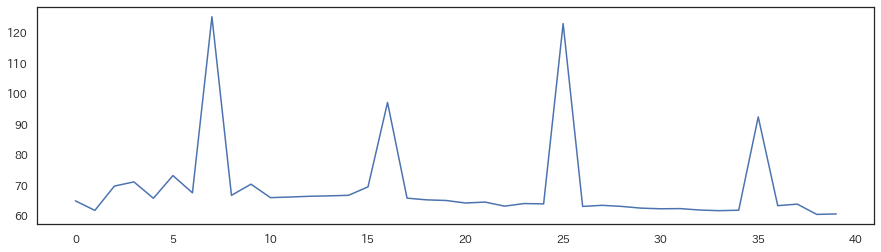

In [179]:
#model1, model2 = learning(trainX,y_train)
pred_test = model1.predict(testX["days"].values.reshape(-1,1)) + model2.predict(testX)
#pred = model1.predict(testX["days"].values.reshape(-1,1)) + model2.predict(testX.iloc[:,~testX.columns.str.match("y")])
plt.figure(figsize=(15,4))
plt.plot(pred_test)

In [180]:
trainX.head()

,precipitation,days,fun,curry,weather_快晴,weather_晴れ,weather_曇,weather_薄曇,weather_雨
0,-1.0,0,0,0,0,1,0,0,0
1,-1.0,1,0,0,0,1,0,0,0
2,-1.0,2,0,0,0,1,0,0,0
3,-1.0,3,0,0,0,0,0,1,0
4,-1.0,4,0,0,0,1,0,0,0


In [181]:
testX.head()

,precipitation,days,fun,curry,weather_快晴,weather_晴れ,weather_曇,weather_薄曇,weather_雨
0,0.0,0,0,0,0,0,0,0,1
1,-1.0,1,0,0,0,0,1,0,0
2,-1.0,2,0,0,0,1,0,0,0
3,0.5,3,0,0,0,0,0,0,1
4,-1.0,4,0,0,0,1,0,0,0


## おまけ

In [148]:
model3 = RF()

In [149]:
parameters = {"n_estimators": list(range(50,200)),"max_depth": list(range(2,10))}

In [182]:
from sklearn.model_selection import GridSearchCV
import pydotplus

In [183]:
gcv = GridSearchCV(model3, parameters,cv=5, scoring="roc_auc", n_jobs=-1, return_train_score=True)
gcv.fit(trainX,y_train)

KeyboardInterrupt: 

In [154]:
gcv.best_params_

{'max_depth': 2, 'n_estimators': 50}

In [156]:
pred3 = gcv.predict(trainX)

In [159]:
pred_train3 = model1.predict(trainX["days"].values.reshape(-1,1)) + gcv.predict(trainX)

In [160]:
print("RMSE",MSE(y_train, pred_train3)**0.5)

RMSE 64.75077953085174


<AxesSubplot:>

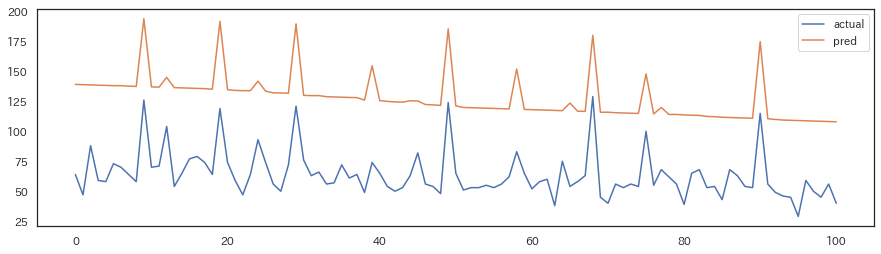

In [185]:
p3 = pd.DataFrame({"actual":y_train,"pred":pred_train3})
p3.plot(figsize=(15,4))

In [186]:
print("RMSE",MSE(y_train, pred3)**0.5)

RMSE 9.565366182906999


<AxesSubplot:>

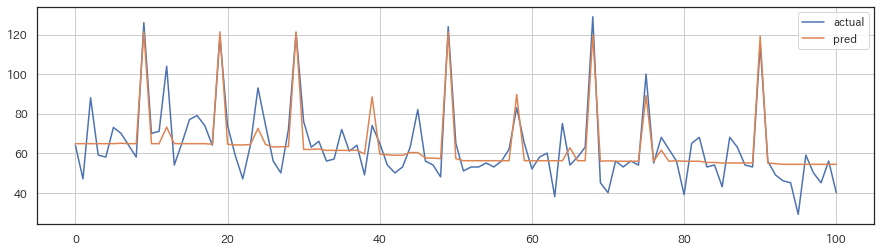

In [189]:
p3 = pd.DataFrame({"actual":y_train,"pred":pred3})
p3.plot(figsize=(15,4),grid=True)